# saved models are named as FreeSound_1D_conv_

In [14]:
import os
import pandas as pd
import librosa
import librosa.display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm.notebook as tqdm
from torchsummary import summary
import torch.optim as optim
os.listdir('data/freesound-audio-tagging')

['audio_test',
 'audio_train',
 'sample_submission.csv',
 'test_post_competition.csv',
 'train.csv',
 'train_post_competition.csv']

In [3]:
len(os.listdir('data/freesound-audio-tagging/audio_train'))
df = pd.read_csv('data/freesound-audio-tagging/train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [82]:
sr = 44100
input_length = int(sr/2)
batch_size = 32


def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5


def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=sr)[0] 
    
    if len(data)>input_length:
        max_offset = len(data)-input_length
        offset = np.random.randint(max_offset)
        data = data[offset:input_length+offset]
        
    else:
        T = np.zeros(input_length, dtype=float)
        T[:len(data)] = data
        data = T
        #max_offset = input_length - len(data)
        ##offset = np.random.randint(max_offset)
        #data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
    data = audio_norm(data)
    return np.array([data])

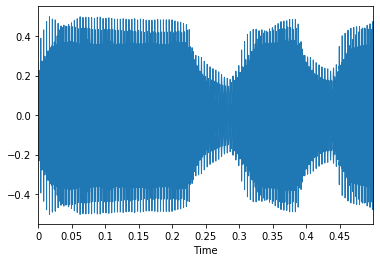

In [83]:
librosa.display.waveplot(load_audio_file('data/freesound-audio-tagging/audio_train/001ca53d.wav')[0],
                         sr=sr, 
                         max_points=50000.0, 
                         x_axis='time', 
                         offset=0.0)

# Data Loading

In [84]:
labels = sorted(set(df.label))
label_to_indice = {l:i for i,l in enumerate(labels)}
indice_to_label = {i:l for i,l in enumerate(labels)}

In [85]:
class FreeSoundDataset(torch.utils.data.Dataset):
    def __init__(self, df_path, data_path, train=True, split=0.8):
        
        self.df = pd.read_csv(df_path)
        
        self.df = self.df[:int(len(self.df)*split)] if train else self.df[int(len(self.df)*split):]
        
        self.data_path = data_path
        self.sr = 44100
        self.input_length = int(sr/2)
        self.batch_size = 32
        
        self.labels = sorted(set(self.df.label))
        self.label_to_indice = {l:i for i,l in enumerate(self.labels)}
        self.indice_to_label = {i:l for i,l in enumerate(self.labels)}
    
    def __len__(self):
        return len(self.df)-2
    
    def __getitem__(self, idx):
        file_path = self.data_path + list(df[idx: idx+1].fname)[0]
        label_indice = label_to_indice[list(df[idx: idx+1].label)[0]]
        return load_audio_file(file_path), label_indice
        

In [86]:
def bandpass_filter(signal, low, high, order = 5):
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    y = sosfilt(sos, signal)
    return y
    
def make_signal(raw_signal, nyq = sr/2):
    return_signal = np.zeros((8, self.input_length))
    return_signal[0] = raw_signal

    cut_offs = [i/nyq for i in [1, 256, 512, 1024, 2048, 4096, 8192, 11024]]
    for i in range(1, len(cut_offs), 1):
        return_signal[i] = bandpass_filter(raw_signal, cut_offs[i-1], cut_offs[i])
    return return_signal
        
    
def shuffletwo(x, y):
    rng_state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(rng_state)
    np.random.shuffle(y)

In [87]:
FreeSoundData = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                 'data/freesound-audio-tagging/audio_train/')
FreeSoundDataTest = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                     'data/freesound-audio-tagging/audio_train/',
                                     train=False)
FreeSoundDataLoader = DataLoader(FreeSoundData, batch_size=32, shuffle=True)
FreeSoundDataTestLoader = DataLoader(FreeSoundDataTest, batch_size=32, shuffle=32)

# Model

In [88]:
class FreeSound_Sense(torch.nn.Module):
    
    def __init__(self):
        super(FreeSound_Sense, self).__init__()
        self.conv1d_1_16_9 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_16_9 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_32_3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_32_3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_256_3 = nn.Conv1d(in_channels=32, out_channels=256, kernel_size=3, padding=True)
        self.conv1d_256_256_3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=True)
        
        self.maxpool_16 = nn.MaxPool1d(16)
        self.maxpool_4 = nn.MaxPool1d(4)
        
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.1)
        
        self.fc_10752_64 = nn.Linear(in_features=5376, out_features=64)
        self.fc_64_1024 = nn.Linear(in_features=64, out_features=1024)
        self.fc_1024_42 = nn.Linear(in_features=1024, out_features=42)
        
        
    def forward(self, x):
        
        # First Block
        x = self.conv1d_1_16_9(x)
        x = self.relu(x)
        x = self.conv1d_16_16_9(x)
        x = self.relu(x)
        x = self.maxpool_16(x)
        x = self.dropout(x)
        
        # Second Block
        x = self.conv1d_16_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Third Block
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Fourth Block
        x = self.conv1d_32_256_3(x)
        x = self.relu(x)
        x = self.conv1d_256_256_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
 
        # Final Layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc_10752_64(x)
        x = self.relu(x)
        x = self.fc_64_1024(x)
        x = self.relu(x)
        x = self.fc_1024_42(x)
        x = self.softmax(x)
        
        return x

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model = FreeSound_Sense()
Model.float()
Model.to(device)
summary(Model, (1, 22050))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 22044]             160
              ReLU-2            [-1, 16, 22044]               0
            Conv1d-3            [-1, 16, 22038]           2,320
              ReLU-4            [-1, 16, 22038]               0
         MaxPool1d-5             [-1, 16, 1377]               0
           Dropout-6             [-1, 16, 1377]               0
            Conv1d-7             [-1, 32, 1377]           1,568
              ReLU-8             [-1, 32, 1377]               0
            Conv1d-9             [-1, 32, 1377]           3,104
             ReLU-10             [-1, 32, 1377]               0
        MaxPool1d-11              [-1, 32, 344]               0
          Dropout-12              [-1, 32, 344]               0
           Conv1d-13              [-1, 32, 344]           3,104
             ReLU-14              [-1, 

In [170]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(Model.parameters(), lr=0.00005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [172]:
epoch_progress_bar = tqdm.tqdm(range(0, 333))
for epoch in epoch_progress_bar:
    avg_epoch_loss = 0
    data_progress_bar = tqdm.tqdm(FreeSoundDataLoader)
    positives=0
    for data, targets in data_progress_bar:
        data = data.float().to(device)
        targets = targets.long().to(device)
        

        optimizer.zero_grad()
        outputs = Model(data)
        

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        avg_epoch_loss+=loss_val
        data_progress_bar.set_description(desc="Loss: "+str(loss_val))
        
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        targets = targets.cpu().numpy()
        positives += np.sum(targets==outputs)
    
    print('Epoch Loss: ', str(avg_epoch_loss/len(FreeSoundDataLoader)))
    print('Train Acc ', str(positives*100/(len(FreeSoundDataLoader)*32)))
    
    # Validation
    data_test_progress_bar = tqdm.tqdm(FreeSoundDataTestLoader)
    positives=0
    for data, targets in data_test_progress_bar:
        data = data.float().to(device)
        targets = targets.numpy()
        outputs = Model(data)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        positives += np.sum(targets==outputs)
        
    print('Valid Acc ', str(positives*100/(len(FreeSoundDataTestLoader)*32)))


Epoch Loss:  3.4563505659626506
Train Acc  32.107067510548525



Valid Acc  31.510416666666668



Epoch Loss:  3.452599813163532
Train Acc  32.42352320675106



Valid Acc  31.09375



Epoch Loss:  3.454587916281656
Train Acc  32.278481012658226



Valid Acc  30.677083333333332



Epoch Loss:  3.4498185507858854
Train Acc  32.72679324894515



Valid Acc  32.447916666666664



Epoch Loss:  3.444575372124523
Train Acc  33.21466244725738



Valid Acc  33.125



Epoch Loss:  3.4494347280590847
Train Acc  32.71360759493671



Valid Acc  31.302083333333332



Epoch Loss:  3.4513918598995934
Train Acc  32.59493670886076



Valid Acc  31.458333333333332



Epoch Loss:  3.442591982048775
Train Acc  33.45200421940928



Valid Acc  31.979166666666668



Epoch Loss:  3.447943579798509
Train Acc  32.950949367088604



Valid Acc  32.083333333333336



Epoch Loss:  3.448235523851612
Train Acc  32.88502109704641



Valid Acc  33.072916666666664



Epoch Loss:  3.448782163330271
Train Acc  32.75316455696203



Valid Acc  30.989583333333332



Epoch Loss:  3.446296229141171
Train Acc  33.13554852320675



Valid Acc  31.458333333333332



Epoch Loss:  3.4401617080350464
Train Acc  33.755274261603375



Valid Acc  33.229166666666664



Epoch Loss:  3.4392634283138226
Train Acc  33.860759493670884



Valid Acc  32.760416666666664



Epoch Loss:  3.4445338822618314
Train Acc  33.24103375527426



Valid Acc  32.8125



Epoch Loss:  3.4393081423602525
Train Acc  33.83438818565401



Valid Acc  31.197916666666668



Epoch Loss:  3.4495122171152492
Train Acc  32.779535864978904



Valid Acc  32.395833333333336



Epoch Loss:  3.441792087715889
Train Acc  33.504746835443036



Valid Acc  31.875



Epoch Loss:  3.445827304059443
Train Acc  33.22784810126582



Valid Acc  31.979166666666668



Epoch Loss:  3.4427351317828214
Train Acc  33.45200421940928



Valid Acc  32.604166666666664



Epoch Loss:  3.442588272979994
Train Acc  33.39926160337553



Valid Acc  31.822916666666668



Epoch Loss:  3.438736007183413
Train Acc  33.87394514767932



Valid Acc  33.4375



Epoch Loss:  3.4435933310271314
Train Acc  33.3201476793249



Valid Acc  32.34375



Epoch Loss:  3.4455041845136556
Train Acc  33.16191983122363



Valid Acc  31.666666666666668



Epoch Loss:  3.443753313917651
Train Acc  33.333333333333336



Valid Acc  32.5



Epoch Loss:  3.4402009424780995
Train Acc  33.676160337552744



Valid Acc  32.395833333333336



Epoch Loss:  3.4457273352498246
Train Acc  33.095991561181435



Valid Acc  33.229166666666664



Epoch Loss:  3.4387200462164254
Train Acc  33.82120253164557



Valid Acc  32.8125



Epoch Loss:  3.440466841564903
Train Acc  33.70253164556962



Valid Acc  32.083333333333336



Epoch Loss:  3.4436201304826053
Train Acc  33.38607594936709



Valid Acc  31.875



Epoch Loss:  3.4421075346097663
Train Acc  33.46518987341772



Valid Acc  32.34375



Epoch Loss:  3.4377486021709847
Train Acc  33.92668776371308



Valid Acc  32.1875



Epoch Loss:  3.441770113973175
Train Acc  33.45200421940928



Valid Acc  32.8125



Epoch Loss:  3.4385596911112466
Train Acc  33.9003164556962



Valid Acc  33.541666666666664



Epoch Loss:  3.4413962847069848
Train Acc  33.58386075949367



Valid Acc  32.5



Epoch Loss:  3.4428710625644476
Train Acc  33.425632911392405



Valid Acc  32.5



Epoch Loss:  3.4416108755119743
Train Acc  33.55748945147679



Valid Acc  32.708333333333336



Epoch Loss:  3.4447026745679508
Train Acc  33.22784810126582



Valid Acc  32.083333333333336



Epoch Loss:  3.4484576816800274
Train Acc  32.83227848101266



Valid Acc  32.8125



Epoch Loss:  3.4422161870867893
Train Acc  33.4915611814346



Valid Acc  32.083333333333336



Epoch Loss:  3.4403484380697904
Train Acc  33.64978902953587



Valid Acc  32.447916666666664



Epoch Loss:  3.441482276353152
Train Acc  33.517932489451475



Valid Acc  32.34375



Epoch Loss:  3.4389827995863644
Train Acc  33.78164556962025



Valid Acc  32.916666666666664



Epoch Loss:  3.4356344188818952
Train Acc  34.12447257383966



Valid Acc  32.96875



Epoch Loss:  3.439028223858604
Train Acc  33.79483122362869



Valid Acc  32.916666666666664



Epoch Loss:  3.4404843084922825
Train Acc  33.64978902953587



Valid Acc  33.802083333333336



Epoch Loss:  3.4307527008941907
Train Acc  34.651898734177216



Valid Acc  32.291666666666664



Epoch Loss:  3.440691699458577
Train Acc  33.62341772151899



Valid Acc  32.760416666666664



Epoch Loss:  3.4397080980775727
Train Acc  33.768459915611814



Valid Acc  32.8125



Epoch Loss:  3.4399922547964104
Train Acc  33.70253164556962



Valid Acc  33.385416666666664



Epoch Loss:  3.4329665381194165
Train Acc  34.44092827004219



Valid Acc  32.916666666666664



Epoch Loss:  3.437229229931087
Train Acc  33.97943037974684



Valid Acc  33.854166666666664



Epoch Loss:  3.4355068639360904
Train Acc  34.15084388185654



Valid Acc  33.75



Epoch Loss:  3.434320617828691
Train Acc  34.25632911392405



Valid Acc  33.958333333333336



Epoch Loss:  3.4386372214128196
Train Acc  33.80801687763713



Valid Acc  31.5625



Epoch Loss:  3.443434066410306
Train Acc  33.35970464135021



Valid Acc  32.96875



Epoch Loss:  3.434963310821147
Train Acc  34.229957805907176



Valid Acc  32.864583333333336



Epoch Loss:  3.4402377675857223
Train Acc  33.70253164556962



Valid Acc  31.770833333333332



Epoch Loss:  3.4398288958183323
Train Acc  33.676160337552744



Valid Acc  33.802083333333336



Epoch Loss:  3.4290493228767494
Train Acc  34.7837552742616



Valid Acc  32.8125



Epoch Loss:  3.438169521621511
Train Acc  33.913502109704645



Valid Acc  32.8125



Epoch Loss:  3.436980529173517
Train Acc  34.084915611814345



Valid Acc  33.125



Epoch Loss:  3.4361655390212302
Train Acc  34.16402953586498



Valid Acc  31.979166666666668



Epoch Loss:  3.43755286554747
Train Acc  33.92668776371308



Valid Acc  32.708333333333336



Epoch Loss:  3.4400185251034765
Train Acc  33.71571729957806



Valid Acc  33.385416666666664



Epoch Loss:  3.435065938450616
Train Acc  34.16402953586498



Valid Acc  33.333333333333336



Epoch Loss:  3.439844575109361
Train Acc  33.7289029535865



Valid Acc  33.854166666666664



Epoch Loss:  3.442070935848896
Train Acc  33.45200421940928



Valid Acc  32.291666666666664



Epoch Loss:  3.444472127825902
Train Acc  33.22784810126582



Valid Acc  33.020833333333336



Epoch Loss:  3.4418353058617828
Train Acc  33.54430379746835



Valid Acc  32.96875



Epoch Loss:  3.441993401523381
Train Acc  33.47837552742616



Valid Acc  32.1875



Epoch Loss:  3.439537494997435
Train Acc  33.70253164556962



Valid Acc  32.239583333333336



Epoch Loss:  3.4377161842861255
Train Acc  33.9003164556962



Valid Acc  33.958333333333336



Epoch Loss:  3.4344499412971206
Train Acc  34.229957805907176



Valid Acc  32.447916666666664



Epoch Loss:  3.4342359550894566
Train Acc  34.26951476793249



Valid Acc  33.020833333333336



Epoch Loss:  3.433363715304604
Train Acc  34.44092827004219



Valid Acc  32.604166666666664



Epoch Loss:  3.4394534599931936
Train Acc  33.7289029535865



Valid Acc  31.614583333333332



Epoch Loss:  3.439369176510517
Train Acc  33.768459915611814



Valid Acc  32.65625



Epoch Loss:  3.433140098797118
Train Acc  34.46729957805907



Valid Acc  32.447916666666664



Epoch Loss:  3.4354678125824103
Train Acc  34.177215189873415



Valid Acc  33.333333333333336



Epoch Loss:  3.4354753735699233
Train Acc  34.1376582278481



Valid Acc  33.28125



Epoch Loss:  3.4321445915769426
Train Acc  34.46729957805907



Valid Acc  32.96875



Epoch Loss:  3.439796976902314
Train Acc  33.70253164556962



Valid Acc  32.5



Epoch Loss:  3.4354473387641744
Train Acc  34.190400843881854



Valid Acc  33.90625



Epoch Loss:  3.434628053053522
Train Acc  34.25632911392405



Valid Acc  32.395833333333336



Epoch Loss:  3.4386438780193087
Train Acc  33.860759493670884



Valid Acc  32.447916666666664



Epoch Loss:  3.4411404525177387
Train Acc  33.59704641350211



Valid Acc  32.8125



Epoch Loss:  3.4346007848087745
Train Acc  34.243143459915615



Valid Acc  33.802083333333336



Epoch Loss:  3.4376188370748912
Train Acc  33.9003164556962



Valid Acc  33.90625



Epoch Loss:  3.434399701371978
Train Acc  34.20358649789029



Valid Acc  34.114583333333336



Epoch Loss:  3.4363911685058337
Train Acc  34.01898734177215



Valid Acc  33.854166666666664



Epoch Loss:  3.43836360339877
Train Acc  33.83438818565401



Valid Acc  33.072916666666664



Epoch Loss:  3.435272670496365
Train Acc  34.190400843881854



Valid Acc  32.916666666666664



Epoch Loss:  3.440777170004221
Train Acc  33.70253164556962



Valid Acc  32.864583333333336



Epoch Loss:  3.438039573436045
Train Acc  33.82120253164557



Valid Acc  33.59375



Epoch Loss:  3.4399276856128678
Train Acc  33.71571729957806



Valid Acc  32.708333333333336



Epoch Loss:  3.4374753664314497
Train Acc  33.93987341772152



Valid Acc  33.385416666666664



Epoch Loss:  3.43568635087476
Train Acc  34.1376582278481



Valid Acc  34.375



Epoch Loss:  3.4356663468517836
Train Acc  34.12447257383966



Valid Acc  32.708333333333336



Epoch Loss:  3.4336262171781518
Train Acc  34.36181434599156



Valid Acc  32.65625



Epoch Loss:  3.433557989225106
Train Acc  34.375



Valid Acc  32.604166666666664



Epoch Loss:  3.442358546116181
Train Acc  33.46518987341772



Valid Acc  32.864583333333336



Epoch Loss:  3.430948198093141
Train Acc  34.6123417721519



Valid Acc  32.760416666666664



Epoch Loss:  3.4332018512210767
Train Acc  34.414556962025316



Valid Acc  32.8125



Epoch Loss:  3.437388913037908
Train Acc  33.9662447257384



Valid Acc  33.072916666666664



Epoch Loss:  3.4356693728563656
Train Acc  34.190400843881854



Valid Acc  33.75



Epoch Loss:  3.435949576051929
Train Acc  34.1376582278481



Valid Acc  32.65625



Epoch Loss:  3.438313054636058
Train Acc  33.9003164556962



Valid Acc  32.760416666666664



Epoch Loss:  3.4320080280303955
Train Acc  34.572784810126585



Valid Acc  33.645833333333336



Epoch Loss:  3.434761457805392
Train Acc  34.243143459915615



Valid Acc  34.6875



Epoch Loss:  3.43506598070201
Train Acc  34.21677215189873



Valid Acc  33.177083333333336



Epoch Loss:  3.4311664768412142
Train Acc  34.62552742616034



Valid Acc  34.53125



Epoch Loss:  3.429721947963731
Train Acc  34.71782700421941



Valid Acc  33.177083333333336



Epoch Loss:  3.4332125307638433
Train Acc  34.375



Valid Acc  34.010416666666664



Epoch Loss:  3.4333895651097035
Train Acc  34.36181434599156



Valid Acc  33.385416666666664



Epoch Loss:  3.433228319707299
Train Acc  34.427742616033754



Valid Acc  32.864583333333336



Epoch Loss:  3.4335085651542565
Train Acc  34.40137130801688



Valid Acc  32.65625



Epoch Loss:  3.43058103448731
Train Acc  34.63871308016878



Valid Acc  33.229166666666664



Epoch Loss:  3.4334730407859704
Train Acc  34.427742616033754



Valid Acc  33.28125



Epoch Loss:  3.4360205191600173
Train Acc  34.098101265822784



Valid Acc  34.53125



Epoch Loss:  3.4334876104749203
Train Acc  34.36181434599156



Valid Acc  33.177083333333336



Epoch Loss:  3.429802090809818
Train Acc  34.73101265822785



Valid Acc  32.604166666666664



Epoch Loss:  3.4335315046431143
Train Acc  34.375



Valid Acc  32.604166666666664



Epoch Loss:  3.4317759471603586
Train Acc  34.506856540084385



Valid Acc  32.604166666666664



Epoch Loss:  3.4371956642166976
Train Acc  33.97943037974684



Valid Acc  33.177083333333336



Epoch Loss:  3.4282197288320035
Train Acc  34.902426160337555



Valid Acc  33.90625



Epoch Loss:  3.430486964777049
Train Acc  34.665084388185655



Valid Acc  34.166666666666664



Epoch Loss:  3.4364991982777915
Train Acc  34.07172995780591



Valid Acc  33.541666666666664



Epoch Loss:  3.432879320176845
Train Acc  34.48048523206751



Valid Acc  34.010416666666664



Epoch Loss:  3.434928675744101
Train Acc  34.243143459915615



Valid Acc  34.375



Epoch Loss:  3.428689751443984
Train Acc  34.836497890295355



Valid Acc  33.020833333333336



Epoch Loss:  3.4347388955611216
Train Acc  34.21677215189873



Valid Acc  33.229166666666664



Epoch Loss:  3.4329444014070405
Train Acc  34.38818565400844



Valid Acc  34.739583333333336



Epoch Loss:  3.4300824177416067
Train Acc  34.67827004219409



Valid Acc  33.4375



Epoch Loss:  3.4315152057615514
Train Acc  34.559599156118146



Valid Acc  33.4375



Epoch Loss:  3.4344430251463556
Train Acc  34.243143459915615



Valid Acc  33.489583333333336



Epoch Loss:  3.4320047817149746
Train Acc  34.53322784810127



Valid Acc  34.0625



Epoch Loss:  3.4322233723185738
Train Acc  34.46729957805907



Valid Acc  33.125



Epoch Loss:  3.4318120328685904
Train Acc  34.54641350210971



Valid Acc  33.489583333333336



Epoch Loss:  3.4360920326619206
Train Acc  34.12447257383966



Valid Acc  32.604166666666664



Epoch Loss:  3.431105940653805
Train Acc  34.62552742616034



Valid Acc  33.333333333333336



Epoch Loss:  3.4368409939456086
Train Acc  34.01898734177215



Valid Acc  32.291666666666664



Epoch Loss:  3.432778005358539
Train Acc  34.40137130801688



Valid Acc  34.427083333333336



Epoch Loss:  3.432294634324086
Train Acc  34.48048523206751



Valid Acc  33.90625



Epoch Loss:  3.4341861406962075
Train Acc  34.29588607594937



Valid Acc  33.75



Epoch Loss:  3.429847249501868
Train Acc  34.744198312236286



Valid Acc  33.385416666666664



Epoch Loss:  3.425193725255974
Train Acc  35.20569620253165



Valid Acc  33.697916666666664



Epoch Loss:  3.432341291934629
Train Acc  34.427742616033754



Valid Acc  33.125



Epoch Loss:  3.4304182821185276
Train Acc  34.70464135021097



Valid Acc  33.854166666666664



Epoch Loss:  3.4349832615268885
Train Acc  34.21677215189873



Valid Acc  32.916666666666664



Epoch Loss:  3.434384197122437
Train Acc  34.28270042194093



Valid Acc  33.28125



Epoch Loss:  3.4335615353242255
Train Acc  34.322257383966246



Valid Acc  32.395833333333336



Epoch Loss:  3.4327243390465587
Train Acc  34.36181434599156



Valid Acc  33.125



Epoch Loss:  3.4344689906397954
Train Acc  34.25632911392405



Valid Acc  32.760416666666664



Epoch Loss:  3.436864112499897
Train Acc  34.04535864978903



Valid Acc  34.479166666666664



Epoch Loss:  3.429472577219774
Train Acc  34.82331223628692



Valid Acc  34.322916666666664



Epoch Loss:  3.4310012809334927
Train Acc  34.6123417721519



Valid Acc  34.84375



Epoch Loss:  3.43670178767498
Train Acc  34.098101265822784



Valid Acc  33.385416666666664



Epoch Loss:  3.4348246437587817
Train Acc  34.243143459915615



Valid Acc  32.708333333333336



Epoch Loss:  3.433104657925634
Train Acc  34.427742616033754



Valid Acc  33.59375



Epoch Loss:  3.4325774631419765
Train Acc  34.49367088607595



Valid Acc  34.427083333333336



Epoch Loss:  3.431075508584453
Train Acc  34.572784810126585



Valid Acc  33.333333333333336



Epoch Loss:  3.4282997288281405
Train Acc  34.902426160337555



Valid Acc  33.854166666666664



Epoch Loss:  3.432332397010256
Train Acc  34.49367088607595



Valid Acc  33.020833333333336



Epoch Loss:  3.4391370554010576
Train Acc  33.80801687763713



Valid Acc  33.229166666666664



Epoch Loss:  3.4319085702614442
Train Acc  34.48048523206751



Valid Acc  33.59375



Epoch Loss:  3.429978571863617
Train Acc  34.651898734177216



Valid Acc  33.072916666666664



Epoch Loss:  3.4342691294754606
Train Acc  34.243143459915615



Valid Acc  34.427083333333336



Epoch Loss:  3.434614208680165
Train Acc  34.26951476793249



Valid Acc  33.697916666666664



Epoch Loss:  3.436888199818285
Train Acc  34.04535864978903



Valid Acc  33.333333333333336



Epoch Loss:  3.436740265616888
Train Acc  33.992616033755276



Valid Acc  32.604166666666664



Epoch Loss:  3.4344294825686683
Train Acc  34.28270042194093



Valid Acc  33.854166666666664



Epoch Loss:  3.4337580324728276
Train Acc  34.375



Valid Acc  33.489583333333336



Epoch Loss:  3.4288711960305642
Train Acc  34.836497890295355



Valid Acc  33.90625



Epoch Loss:  3.4278033936577006
Train Acc  34.92879746835443



Valid Acc  35.260416666666664



Epoch Loss:  3.4353624516901586
Train Acc  34.16402953586498



Valid Acc  33.333333333333336



Epoch Loss:  3.428543636064489
Train Acc  34.81012658227848



Valid Acc  34.479166666666664



Epoch Loss:  3.433275162419186
Train Acc  34.38818565400844



Valid Acc  33.333333333333336



Epoch Loss:  3.4268391574988386
Train Acc  34.994725738396625



Valid Acc  33.229166666666664



Epoch Loss:  3.4337845281206607
Train Acc  34.335443037974684



Valid Acc  33.854166666666664



Epoch Loss:  3.437096830158797
Train Acc  33.97943037974684



Valid Acc  34.010416666666664



Epoch Loss:  3.4365085710453083
Train Acc  34.084915611814345



Valid Acc  32.1875



Epoch Loss:  3.4344316856770574
Train Acc  34.26951476793249



Valid Acc  33.385416666666664


KeyboardInterrupt: 

In [173]:
torch.save(Model.state_dict(), "FreeSound_1D_conv_1183_epoch.stDict")

In [174]:
i=0
for data in FreeSoundDataLoader:
    if i==4:
        O = Model(data[0].float().to(device))
        A = data[1]
        #print(data[1])
        break
    i+=1
O = O.detach().cpu().numpy()
K = np.argmax(O, axis=1)==A.numpy()
print(np.sum(K)/len(K), np.sum(K))
list(zip(A, K))

0.3125 10


[(tensor(0), False),
 (tensor(3), True),
 (tensor(12), False),
 (tensor(25), False),
 (tensor(15), True),
 (tensor(20), False),
 (tensor(4), False),
 (tensor(12), False),
 (tensor(34), False),
 (tensor(13), False),
 (tensor(24), False),
 (tensor(26), True),
 (tensor(7), False),
 (tensor(22), False),
 (tensor(40), True),
 (tensor(20), True),
 (tensor(17), True),
 (tensor(32), True),
 (tensor(7), False),
 (tensor(24), False),
 (tensor(29), False),
 (tensor(10), False),
 (tensor(38), True),
 (tensor(34), False),
 (tensor(30), True),
 (tensor(17), False),
 (tensor(26), True),
 (tensor(18), False),
 (tensor(12), False),
 (tensor(17), False),
 (tensor(1), False),
 (tensor(39), False)]